# Introduction

The following dataset has een downloaded from kaggle (ref https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality?resource=download). The dataset contains attributes about a set of fruits as:

1. A_id: Unique identifier for each fruit
2. Size: Size of the fruit
3. Weight: Weight of the fruit
4. Sweetness: Degree of sweetness of the fruit
5. Crunchiness: Texture indicating the crunchiness of the fruit
6. Juiciness: Level of juiciness of the fruit
7. Ripeness: Stage of ripeness of the fruit
8. Acidity: Acidity level of the fruit
9. Quality: Overall quality of the fruit

The object of the current notebook is to develop a model ale to classify the different types of fruits. The data has been scaled and cleaned for ease of use.

# Analyzing data

In [12]:
import pandas as pd

In [13]:
apple_quality_df = pd.read_csv('apple_quality.csv')

In [14]:
apple_quality_df.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


Clearly the statistics above show that the dataset has features already scaled and there are no missing values for each feature. However, oserving the data we notice that row 4000 contains non useful information therefore we remove it:

In [15]:
apple_quality_df = apple_quality_df.iloc[:4000, :]

The ojective is to classify the fruits quality ased on the other features. The possible categories are:

In [16]:
apple_quality_df["Quality"].drop_duplicates().values

array(['good', 'bad'], dtype=object)

Therefore we have a binary classification and we try to predict if the fruit is good or ad based on the available features. Let's first encode the two classed using 1 for good quality and 0 for ad quality:

In [17]:
encoding_dict = {"good": 1, "bad": 0}
apple_quality_df["Quality"] = apple_quality_df["Quality"].map(encoding_dict)

In [18]:
number_of_good_fruits = apple_quality_df["Quality"].sum()
number_of_bad_fruits = apple_quality_df["Quality"].shape[0] - number_of_good_fruits
print(f" Number good fruits: {number_of_good_fruits}, number of ad fruits {number_of_bad_fruits}")

 Number good fruits: 2004, number of ad fruits 1996


The dataset is slightly inbalanced towards the good quality class 

# Box Plots

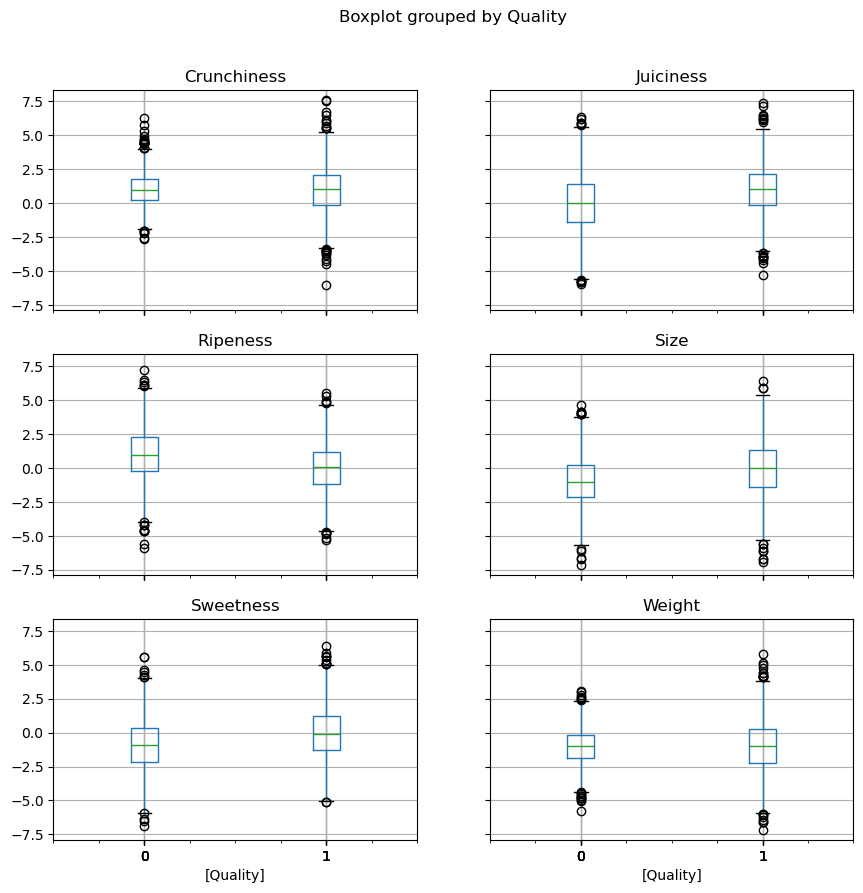

In [19]:
import matplotlib.pyplot as plt
columns = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness',
       'Ripeness', 'Acidity', 'Quality']
apple_quality_df[columns].boxplot(by="Quality", figsize=(10,10))
plt.show()

## Creation of the model features and label

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

In [21]:
feature_to_consider = ['Juiciness', 'Ripeness', 'Size', 'Sweetness']
X = apple_quality_df[feature_to_consider]

Y = apple_quality_df["Quality"]

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Baseline model predicting always the most frequent class

In [26]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import accuracy_score

In [27]:
class BaselineEstimator(BaseEstimator, RegressorMixin):
    
    """ Estimator that gives a baseline prediction for regression or classification model"""
    
    def __init__(self, mode):
        self.mode = mode
    
    def fit(self, X, y=None):
        
        if self.mode == "most frequent":
            
            counts = np.bincount(y)
            self.predicted_value = np.argmax(counts)
            
        elif self.mode == "mean":
            self.predicted_value = np.mean(y)
            
        else:
            raise Exception('Mode not supported ! (most frequent / mean)')
        
        
    def predict(self, X):
        return self.predicted_value * np.ones(X.shape[0])

In [28]:
baseline_estimator = BaselineEstimator("most frequent")
baseline_estimator.fit(X_train, Y_train)
Y_pred = baseline_estimator.predict(X_test)
print(f" Accuracy of the model predicting always the most frequent class: {accuracy_score(Y_pred, Y_test)}")

 Accuracy of the model predicting always the most frequent class: 0.5


## Trying different types of models

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [32]:
SVC?

In [55]:
logistic_regression = LogisticRegression()
logistic_regression_param_grid = {"C": np.linspace(0.1, 2.0, num=20)}
support_vector_machine_classifier = SVC()
support_vector_param_grid = {"C": np.linspace(1, 10, 10), "kernel":['linear', 'poly', 'rbf', 'sigmoid'], "degree": [1,2,3,4]}

random_forest_classifier = RandomForestClassifier()
random_forest_param_grid = {'max_depth': np.arange(1,10)}

In [57]:
dict_cross_validation = {
    logistic_regression : logistic_regression_param_grid,
    random_forest_classifier: random_forest_param_grid,
    support_vector_machine_classifier: support_vector_param_grid
}

result = []
 
for estimator, param_grid in dict_cross_validation.items():
    gs = GridSearchCV(estimator, param_grid)

    gs.fit(X_train, Y_train)
    

    result.append((gs.best_estimator_, gs.best_score_))

In [58]:
result


[(LogisticRegression(C=0.5), 0.7271875000000001),
 (RandomForestClassifier(max_depth=9), 0.8115625),
 (SVC(C=7.0, degree=1), 0.8262500000000002)]

In [63]:
final_model = result[2][0]
Y_pred = final_model.predict(X_test)

In [64]:
accuracy_score(Y_pred, Y_test)

0.80125

## Model Export into pickle file for future usage

In [65]:
from joblib import dump, load
dump(final_model, "svc_classifier.joblib")

b'\x80\x04\x95\xf7\x1b\x01\x00\x00\x00\x00\x00\x8c\x14sklearn.svm._classes\x94\x8c\x03SVC\x94\x93\x94)\x81\x94}\x94(\x8c\x17decision_function_shape\x94\x8c\x03ovr\x94\x8c\nbreak_ties\x94\x89\x8c\x06kernel\x94\x8c\x03rbf\x94\x8c\x06degree\x94K\x01\x8c\x05gamma\x94\x8c\x05scale\x94\x8c\x05coef0\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x03tol\x94G?PbM\xd2\xf1\xa9\xfc\x8c\x01C\x94\x8c\x15numpy.core.multiarray\x94\x8c\x06scalar\x94\x93\x94\x8c\x05numpy\x94\x8c\x05dtype\x94\x93\x94\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94bC\x08\x00\x00\x00\x00\x00\x00\x1c@\x94\x86\x94R\x94\x8c\x02nu\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x07epsilon\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\tshrinking\x94\x88\x8c\x0bprobability\x94\x89\x8c\ncache_size\x94K\xc8\x8c\x0cclass_weight\x94N\x8c\x07verbose\x94\x89\x8c\x08max_iter\x94J\xff\xff\xff\xff\x8c\x0crandom_state\x94N\x8c\x07_sparse\x94\x89\x8c\x11feature_names_in_\x94h\x10\x8c\x0c_reconstruct\x94\x